# Load the model

In this unit we will look at how to load a model along with it's persisted parameter states and inference model predictions.

In [1]:
%matplotlib inline
import torch
import onnxruntime
from torch import nn
import torch.onnx as onnx
import torchvision.models as models
from torchvision import datasets
from torchvision.transforms import ToTensor

To load the model, we will define the model class which contains the state and parameters of the neural network used to train the model.

In [2]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

When loading model weights, we needed to instantiate the model class first, because the class defines the structure of a network. Next, we load the parameters using the `load_state_dict()` method.

In [3]:
model = NeuralNetwork()
model.load_state_dict(torch.load('data/model.pth'))
model.eval()

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
    (5): ReLU()
  )
)

> **Note:** Be sure to call `model.eval()` method before inferencing to set the dropout and batch normalization layers to evaluation mode. Failing to do this will yield inconsistent inference results.


## Model Inference

Optimizing a models to run on a variety of platforms and programming languages is difficult. It's very time consuming to maximize performance across all the different combinations of frameworks and hardware. The **Open Neural Network Exchange (ONNX)** runtime provides a solution for you to train once and acelerate inference on any hardward, cloud or edge devices is needed. 

ONNX  is a common format supported by a number of vendors to share neural networks and other machine learning models. You can use ONNX format to do inference on your model on other programming languages and frameworks such as Java, JavaScript, C# and ML.NET

## Exporting the model to ONNX

PyTorch also has native ONNX export support. Given the dynamic nature of the PyTorch execution graph, however, the export process must traverse the execution graph to produce a persisted ONNX model. For this reason, a test variable of the appropriate size should be passed in to the export routine (in our case, we will create a dummy zero tensor of the correct size.  You can get the size from the `shape` fuction on your training dataset. e.g tensor.shape):

In [4]:
input_image = torch.zeros((1,28,28))
onnx_model = 'data/model.onnx'
onnx.export(model, input_image, onnx_model)

We will use our test dataset as sample data for inference from the ONNX model to make predictions.


In [5]:
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]


We need to create inference session with `onnxruntime.InferenceSession`.  To inference the onnx model, use run and pass in the list of outputs you want returned (leave empty if you want all of them) and a map of the input values. The result is a list of the outputs.

In [7]:
import matplotlib.pyplot as plt

Predicted: "Sneaker", Actual: "Sneaker"


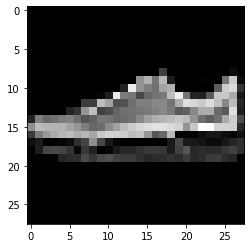

In [11]:
index = 9
x, y = test_data[index][0], test_data[index][1]
session = onnxruntime.InferenceSession(onnx_model, None)
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

result = session.run([output_name], {input_name: x.numpy()})
predicted, actual = classes[result[0][0].argmax(0)], classes[y]
print(f'Predicted: "{predicted}", Actual: "{actual}"')
plt.imshow(x.squeeze(), cmap='gray')

There are a lot of things you can do with ONNX model, including running inference on different platforms and in different programming languages. 